In [1]:
import matplotlib.pyplot as plt
import numba
import numpy as np

As an example, consider the Hamiltonian for the Shiba lattice

https://www.nature.com/articles/ncomms12297

$$ H_k = \tau_z \left(
\varepsilon_k \sigma_0 + \boldsymbol{\alpha}_k \cdot \boldsymbol{\sigma}
\right)
+ J \tau_0 \sigma_z
+ \Delta \tau_x \sigma_0 $$

$$ \varepsilon_k = -2t (\cos(k_x) + \cos(k_y)) - \mu $$

$$ \boldsymbol{\alpha}_k = -2\alpha \begin{pmatrix}
\sin(k_y) \\
-\sin(k_x) \\
0
\end{pmatrix} $$

In [2]:
@numba.njit
def calc_Hk(k, params):
    """Calculate the Hamiltonian matrix in k-space.

    Uses the spinor:
    ψ† = (c†↑, c†↓, c↓, -c↑)

    Parameters
    ----------
    k : array_like
        Momentum (kx, ky).
    params : list
        List of parameters [t, μ, α, Δ, J].
        t - hopping
        μ - chemical potential
        α - Rashba coupling
        Δ - superconducting order parameter
        J - Zeeman/exchange coupling

    Returns
    -------
    Hk : ndarray
        4x4 Hamiltonian matrix in τσ space.
    """
    t, mu, alpha, Delta, J = params
    
    # Dispersion
    epsk = -2*t*(np.cos(k[0]) + np.cos(k[1])) - mu
    # Rashba
    alpk = -2*alpha*np.array([np.sin(k[1]), -np.sin(k[0])])
    # Construct matrix
    return np.array([
        [epsk+J, alpk[0]-1j*alpk[1], Delta, 0],
        [alpk[0]+1j*alpk[1], epsk-J, 0, Delta],
        [Delta, 0, -epsk+J, -alpk[0]+1j*alpk[1]],
        [0, Delta, -alpk[0]-1j*alpk[1], -epsk-J]
    ])

In [3]:
@numba.njit
def calc_Ek(Hk_func, Norb, params, Nk=256):
    """Calculate the energies on a meshgrid.

    Parameters
    ----------
    Hk_func : function
        Function that returns the Hamiltonian matrix.
    Norb : int
        Dimension of Hamiltonian matrix.
    params : list
        List of parameters.
    Nk : int
        Number of k-points in each direction.

    Returns
    -------
    Ek : ndarray(Nk, Nk, Norb)
        Energy eigenvalues.
    """
    # Calculate evenly spaced k-points from 0 to 2π
    k = 2*np.pi/Nk * np.arange(Nk)
    Ek = np.empty((Nk, Nk, Norb))
    for i in range(Nk):
        for j in range(Nk):
            # Get Hamiltonian
            Hk = Hk_func((k[i], k[j]), params)
            # Calculate eigenvalues
            Ek[i,j] = np.linalg.eigvalsh(Hk)
    return Ek

In [4]:
Nk = 256
params = 1., -4., 0.2, 0.3, 0.5

In [5]:
kx, ky = 2*np.pi/Nk * np.mgrid[:Nk, :Nk]
Ek = calc_Ek(calc_Hk, 4, params, Nk)

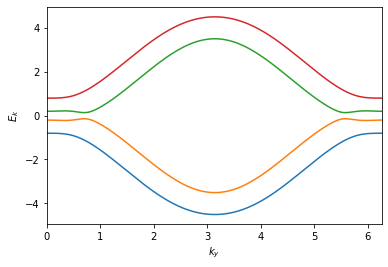

In [6]:
fig, ax = plt.subplots()
ax.plot(ky[0], Ek[0])
ax.set_xlim(ky[0,0], ky[0,-1])
ax.set_xlabel('$k_y$')
ax.set_ylabel('$E_k$')
plt.show()

# Chern number using the projector representation

$$ C = \frac{1}{2\pi i} \int d^2k \mathrm{Tr} P_k \left[
\partial_{k_x} P_k, \partial_{k_y} P_k
\right] $$

$$\approx \frac{1}{2\pi i} \left(\frac{2\pi}{N}\right)^2 \sum_k \mathrm{Tr} P_k \left[
\partial_{k_x} P_k, \partial_{k_y} P_k
\right] $$

$$ P_k = \sum_{E_k^{(n)} < 0} |\psi_k^{(n)} \rangle \langle \psi_k^{(n)} | $$

Using the numpy definition for the DFT
$$ F_k = \sum_r f_r e^{-ikr} $$
and the inverse
$$ f_r = \frac{1}{N} \sum_k F_k e^{ikr} $$
the derivative can be calculated using
$$ \partial_k F_k
= \sum_r \partial_k f_r e^{-ikr}
= \sum_r (-ir) f_r e^{-ikr}$$

In [7]:
@numba.njit
def chern_P(Hk_func, Norb, params, Nk=256):
    """Calculate the Chern number using the projector representation.

    Parameters
    ----------
    Hk_func : function
        Function that returns the Hamiltonian matrix.
    Norb : int
        Dimension of Hamiltonian matrix.
    params : list
        List of parameters.
    Nk : int
        Number of k-points in each direction.

    Returns
    -------
    C : float
        Chern number.
    """
    k = 2*np.pi/Nk * np.arange(Nk)
    Pk = np.empty((Nk, Nk, Norb, Norb), np.complex128)
    for i in range(Nk):
        for j in range(Nk):
            # Diagonalize Hamiltonian
            Hk = Hk_func((k[i], k[j]), params)
            Ek, psik = np.linalg.eigh(Hk)
            # Get occupied states (energy < 0)
            n = np.searchsorted(Ek, 0)
            psi = psik[:,:n]
            # Calculate projection
            Pk[i,j] = psi.dot(psi.T.conj())

    # Use object mode since numba doesn't have FFT
    with numba.objmode(d1Pk='complex128[:,:,:,:]', d2Pk='complex128[:,:,:,:]'):
        # Calculate x derivative
        x = np.fft.fftfreq(Nk, 1/Nk).reshape(-1, 1, 1, 1)
        d1Pk = np.fft.fft(-1j*x*np.fft.ifft(Pk, axis=0), axis=0)
        
        # Calculate y derivative
        y = np.fft.fftfreq(Nk, 1/Nk).reshape(1, -1, 1, 1)
        d2Pk = np.fft.fft(-1j*y*np.fft.ifft(Pk, axis=1), axis=1)

    # Integrate
    C = 0
    for i in range(Nk):
        for j in range(Nk):
            comm = d1Pk[i,j].dot(d2Pk[i,j]) - d2Pk[i,j].dot(d1Pk[i,j])
            C += np.trace(Pk[i,j].dot(comm).imag)
    C *= (2*np.pi/Nk)**2 / (2*np.pi)
    
    return C

In [8]:
chern_P(calc_Hk, 4, params, Nk)

<ipython-input-7-3da427086311>:32: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(complex128, 2d, A), array(complex128, 2d, C))
  Pk[i,j] = psi.dot(psi.T.conj())
<ipython-input-7-3da427086311>:48: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(complex128, 2d, A), array(complex128, 2d, A))
  comm = d1Pk[i,j].dot(d2Pk[i,j]) - d2Pk[i,j].dot(d1Pk[i,j])


-0.999999999999969

# Fukui Hatsugai Suzuki algorithm

https://journals.jps.jp/doi/10.1143/JPSJ.74.1674

In [9]:
@numba.njit
def chern_FHS(Hk_func, Norb, params, Nk=32):
    """Calculate the Chern number using the Fukui Hatsugai Suzuki algorithm.

    Parameters
    ----------
    Hk_func : function
        Function that returns the Hamiltonian matrix.
    Norb : int
        Dimension of Hamiltonian matrix.
    params : list
        List of parameters.
    Nk : int
        Number of k-points in each direction.

    Returns
    -------
    C : ndarray
        Chern number of each band.
    """
    k = 2*np.pi/Nk * np.arange(Nk)
    nk = np.empty((Nk, Nk, Norb, Norb), np.complex128)
    for i in range(Nk):
        for j in range(Nk):
            # Calculate wavefunctions
            Hk = Hk_func((k[i], k[j]), params)
            Ek, nk[i,j] = np.linalg.eigh(Hk)

    U1 = np.empty((Norb, Nk, Nk), np.complex128)
    U2 = np.empty((Norb, Nk, Nk), np.complex128)
    for i in range(Nk):
        for j in range(Nk):
            for n in range(Norb):
                # Get n-th wavefunction at k, k+δk_1, k+δk_2
                nk0 = nk[i,j,:,n]
                nk1 = nk[(i+1)%Nk,j,:,n]
                nk2 = nk[i,(j+1)%Nk,:,n]
                
                # Calculate U(1) link variable for each direction
                U1[n,i,j] = nk0.conj().dot(nk1)
                U1[n,i,j] /= np.abs(U1[n,i,j])
                
                U2[n,i,j] = nk0.conj().dot(nk2)
                U2[n,i,j] /= np.abs(U2[n,i,j])
                
    
    C = np.zeros(Norb)
    for n in range(Norb):
        for i in range(Nk):
            for j in range(Nk):
                # Calculate lattice field strength
                F12 = np.log(U1[n,i,j] * U2[n,(i+1)%Nk,j] / (U1[n,i,(j+1)%Nk] * U2[n,i,j])).imag
                
                # Sum
                C[n] += F12

    return C / (2*np.pi)

In [10]:
chern_FHS(calc_Hk, 4, params, Nk)

<ipython-input-9-c92d845111c8>:40: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(complex128, 1d, C), array(complex128, 1d, A))
  U1[n,i,j] = nk0.conj().dot(nk1)


array([ 3.04201367e-16, -1.00000000e+00,  1.00000000e+00,  5.92946019e-18])

In [11]:
%timeit chern_P(calc_Hk, 4, params, Nk)

501 ms ± 967 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%timeit chern_FHS(calc_Hk, 4, params, Nk)

363 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
# Compare Chern number for different size grids
Nks = np.array([16, 32, 64, 128, 256])
C_P = np.empty(Nks.size)
C_FHS = np.empty(Nks.size)
for i, Nk in enumerate(Nks):
    C_P[i] = chern_P(calc_Hk, 4, params, Nk)
    # Sum of occupied bands
    C_FHS[i] = chern_FHS(calc_Hk, 4, params, Nk)[:2].sum()

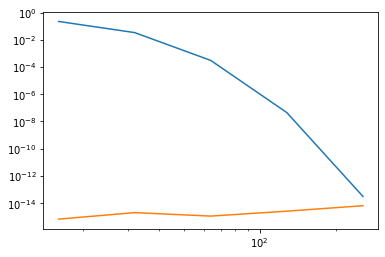

In [14]:
fig, ax = plt.subplots()
ax.loglog(Nks, np.abs(-1 - C_P))
ax.loglog(Nks, np.abs(-1 - C_FHS))
plt.show()

# Real-space Chern number

In [15]:
# Pauli matrices and tensor products
pauli=np.array([
    [[1, 0], [0, 1]],
    [[0, 1], [1, 0]],
    [[0, -1j], [1j, 0]],
    [[1, 0], [0, -1]]])
tzs0 = np.kron(pauli[3], pauli[0])
tzsx = np.kron(pauli[3], pauli[1])
tzsy = np.kron(pauli[3], pauli[2])
t0sx = np.kron(pauli[0], pauli[1])
t0sy = np.kron(pauli[0], pauli[2])
t0sz = np.kron(pauli[0], pauli[3])
txs0 = np.kron(pauli[1], pauli[0])

def hamiltonian(params, N=32):
    """Calculate the Hamiltonian matrix in real-space.

    Uses the spinor:
    ψ† = (c†↑, c†↓, c↓, -c↑)

    Parameters
    ----------
    params : list
        List of parameters [t, μ, α, Δ, J].
        t - hopping
        μ - chemical potential
        α - Rashba coupling
        Δ - superconducting order parameter
        J - Zeeman/exchange coupling
    N : int
        Number of sites in each direction.

    Returns
    -------
    H : ndarray
        (N*N*4)x(N*N*4) Hamiltonian matrix in xyτσ space.
    """
    t, mu, alpha, Delta, J = params    
    
    # Construct Hamiltonian with indices x, y, στ, x', y', στ'
    H = np.zeros((N, N, 4, N, N, 4), complex)
    for x, y in np.ndindex(N, N):
        # onsite potential
        H[x,y,:,x,y,:] = -mu * tzs0 + J * t0sz + Delta * txs0
        # x and y hoppings
        H[x,y,:,(x+1)%N,y,:] = -t * tzs0 + 1j*alpha * tzsy
        H[x,y,:,x,(y+1)%N,:] = -t * tzs0 - 1j*alpha * tzsx
        # Hermitian conjugates
        H[(x+1)%N,y,:,x,y,:] = -t * tzs0 - 1j*alpha * tzsy
        H[x,(y+1)%N,:,x,y,:] = -t * tzs0 + 1j*alpha * tzsx

    # Reshape into matrix
    return H.reshape(4*N*N, 4*N*N)

In [16]:
N = 32
H = hamiltonian(params, N)

# Get the coordinates of each index
coords = np.empty((2, N, N, 4))
for x, y in np.ndindex(N, N):
    coords[0,x,y,:] = x
    coords[1,x,y,:] = y
coords = coords.reshape(2, -1)

We calculate the Chern number in k-space using the discretization
$$ C = \frac{1}{2\pi i} \left(\frac{2\pi}{N}\right)^2 \sum_k \mathrm{Tr} P_k \left[
\partial_{k_x} P_k, \partial_{k_y} P_k
\right] $$

We define the matrices
$$ P = \sum_k |k \rangle P_k \langle k| $$
$$ \delta_\mu P = \frac{2\pi}{N} \sum_k |k \rangle \partial_{k_\mu} P_k \langle k| $$
$P$ is the full projector and is the direct sum of $P_k$, i.e. we create a large matrix with each k-point as a diagonal block.
$$ P = \begin{pmatrix}
P_{k_1} & & \\
& \ddots & \\
& & P_{k_M}
\end{pmatrix} $$

The integral is now represented as a trace
$$ C = \frac{1}{2\pi i} \mathrm{Tr} P \left[
\delta_{x} P, \delta_{y} P
\right] $$

Since the trace is invariant under transformations, we can calculate the $P$ and $\delta_\mu P$ matrices in real-space using Fourier transforms.

$$ P_{rr'} = \sum_{E_k^{(n)} < 0} \langle r |\psi^{(n)} \rangle \langle \psi^{(n)} | r' \rangle $$

$$ \delta_\mu P_{rr'} = \frac{2\pi i}{N} (r'-r) \cdot \hat{\mu} P_{rr'} $$

We define
$$ K_{rr'}^{(\mu)} = \frac{2\pi}{N} (r'-r) \cdot \hat{\mu} \; J_{d}$$
($J$ is the matrix of ones and $d$ is the dimension of $P_k$)

The $\delta_\mu P$ matrices are the Hadamard (element-wise) product of $K^{(\mu)}$ and $P$.
$$ \delta_\mu P = i K^{(\mu)} \circ P $$

In [17]:
@numba.njit
def remainder(x, p):
    """Calculate mod(x+p/2, p) - p/2.

    Parameters
    ----------
    x : float
        Dividend.
    p : float
        Divisor.

    Returns
    -------
    x : float
        Remainder in (-p/2, p/2].
    """
    while x > p/2:
        x -= p
    while x <= -p/2:
        x += p
    return x

@numba.njit
def kernel(coords):
    """Calculate the kernel matrix for the Chern number.

    Parameters
    ----------
    coords : ndarray
        (x,y) for each index.

    Returns
    -------
    K1, K2 : ndarray
        Kernel matrices.
    """
    # Get number of indices
    N = coords.shape[-1]
    # Get size of each direction
    N1 = np.ptp(coords[0]) + 1
    N2 = np.ptp(coords[1]) + 1

    K1 = np.empty((N, N))
    K2 = np.empty((N, N))
    for i in range(N):
        for j in range(N):
            K1[i,j] = 2*np.pi/N1 * remainder(coords[0,j] - coords[0,i], N1)
            K2[i,j] = 2*np.pi/N2 * remainder(coords[1,j] - coords[1,i], N2)
    return K1, K2

def chern_RS(P, K1, K2):
    """Calculate the Chern number using the real-space method.

    Parameters
    ----------
    P : ndarray
        Projection matrix.
    K1 : ndarray
        Kernel matrix in 1 direction.
    K2 : ndarray
        Kernel matrix in 2 direction.

    Returns
    -------
    C : float
        Chern number.
    """
    # Calculate commutator
    d1P = K1*P
    d2P = K2*P
    comm = d1P.dot(d2P) - d2P.dot(d1P)
    # Tr[A.B] = sum_{i,j} A_{ij} B_{ji}
    Tr = np.sum((P * comm.T).imag)
    return -Tr/(2*np.pi)

In [18]:
# Calculate the projection matrix
en, wf = np.linalg.eigh(H)
P = wf[:,:2*N*N].dot(wf[:,:2*N*N].T.conj())

In [19]:
K1, K2 = kernel(coords)

In [20]:
chern_RS(P, K1, K2)

-0.9661804207243367

In [21]:
chern_P(calc_Hk, 4, params, N)

-0.9661804207243767

# Disorder and Chern number density

We showed that the Chern number can be calculated in real-space using
$$ C = \frac{1}{2\pi i} \mathrm{Tr} P \left[
\delta_{x} P, \delta_{y} P
\right] $$

Since the trace includes a sum over space, we can look at the summand of the trace
$$ C = \frac{1}{2\pi i} \sum_r \langle r | \mathrm{Tr}_{d} P \left[
\delta_{x} P, \delta_{y} P
\right] | r \rangle $$
where $\mathrm{Tr}_d$ is a partial trace over internal degrees of freedom.
We call this the Chern number density.

$$ C_r = \frac{N^2}{2\pi i} \langle r | \mathrm{Tr}_{d} P \left[
\delta_{x} P, \delta_{y} P
\right] | r \rangle $$
$$ C = \frac{1}{N^2} \sum_r C_r $$

The factor $N^2$ is introduced so that the Chern number density doesn't scale with system size.

In [22]:
def disorder_hamiltonian(params, N=32, wJ=0, wU=0):
    """Calculate the Hamiltonian matrix in real-space with disorder.

    Uses the spinor:
    ψ† = (c†↑, c†↓, c↓, -c↑)

    Parameters
    ----------
    params : list
        List of parameters [t, μ, α, Δ, J].
        t - hopping
        μ - chemical potential
        α - Rashba coupling
        Δ - superconducting order parameter
        J - Zeeman/exchange coupling
    N : int
        Number of sites in each direction.
    wJ : float
        Magnetic disorder strength.
    wU : float
        Potential disorder strength.

    Returns
    -------
    H : ndarray
        (N*N*4)x(N*N*4) Hamiltonian matrix in xyτσ space.
    """
    t, mu, alpha, Delta, J = params    
    
    # Construct Hamiltonian with indices x, y, στ, x', y', στ'
    H = np.zeros((N, N, 4, N, N, 4), complex)
    for x, y in np.ndindex(N, N):
        B = J + np.random.uniform(-wJ, wJ)
        V = -mu + np.random.uniform(-wU, wU)
        # onsite potential
        H[x,y,:,x,y,:] = V * tzs0 + B * t0sz + Delta * txs0
        # x and y hoppings
        H[x,y,:,(x+1)%N,y,:] = -t * tzs0 + 1j*alpha * tzsy
        H[x,y,:,x,(y+1)%N,:] = -t * tzs0 - 1j*alpha * tzsx
        # Hermitian conjugates
        H[(x+1)%N,y,:,x,y,:] = -t * tzs0 - 1j*alpha * tzsy
        H[x,(y+1)%N,:,x,y,:] = -t * tzs0 + 1j*alpha * tzsx

    # Reshape into matrix
    return H.reshape(4*N*N, 4*N*N)

def chern_density(P, K1, K2):
    """Calculate the Chern number density using the real-space method.

    Parameters
    ----------
    P : ndarray
        Projection matrix.
    K1 : ndarray
        Kernel matrix in 1 direction.
    K2 : ndarray
        Kernel matrix in 2 direction.

    Returns
    -------
    C : float
        Chern number.
    """
    # Calculate commutator
    d1P = K1*P
    d2P = K2*P
    comm = d1P.dot(d2P) - d2P.dot(d1P)
    # Tr[A.B] = sum_{i,j} A_{ij} B_{ji}
    Tr = np.sum((P * comm.T).imag, axis=1)
    return -Tr/(2*np.pi)

In [23]:
H = disorder_hamiltonian(params, N, wJ=0.1)
# Calculate the projection matrix
en, wf = np.linalg.eigh(H)
P = wf[:,:2*N*N].dot(wf[:,:2*N*N].T.conj())
C_r = N*N*chern_density(P, K1, K2).reshape(N, N, 4).sum(-1)

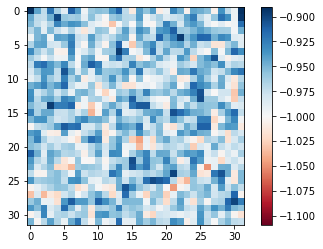

In [24]:
vmax = np.abs(-1 - C_r).max()
fig, ax = plt.subplots()
im = ax.imshow(C_r, vmin=-1-vmax, vmax=-1+vmax, cmap='RdBu')
fig.colorbar(im, ax=ax)
plt.show()

In [25]:
C_r.mean()

-0.9653280218803255